# Breast Cancer Detection with PySpark


## Table of Content

[Purpose](#purpose)   
[Environment Setup](#spark-setup)     
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

This experiment aims to try to find out how we can diagnose breast cancer, using the
machine learning methods using Spark Environment from the features created by
digitizing the images of breast cancer. 

## Environment Setup <a class="anchor" id="spark-setup"></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Understanding<a class="anchor" id="data_understanding"></a>

In [0]:
# import the data and quickly check the format
url = 'https://raw.githubusercontent.com/brainoverflow98/pyspark-breast-cancer-detection/master/data.csv'
sdf = spark.createDataFrame(pd.read_csv(url))
sdf.show(10)

+--------+---------+-----------+------------+--------------+---------+-------------------+----------------+-------------------+-------------------+-------------+----------------------+---------+------------------+------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|    smoothness_mean|compactness_mean|     concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|        texture_se|      perimeter_se|area_se|       smoothness_se|      compactness_se|        concavity_se|   concave points_se|         symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|c

In [0]:
# total number of columns
sdf.count()

569

In [0]:
# check the data types
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_

In [0]:
sdf.describe().show()

+-------+--------------------+---------+------------------+-----------------+------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+----------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+-----------+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|    perimeter_mean|         area_mean|     smoothness_mean|    compactness_mean|     concavity_mean|concave points_mean|       symmetry_mean|fractal_dimension_mean|          radius_se|        texture_se|      perimeter_se|           area_se|       smoothness_se|     

In [0]:
# check the number of null values each column contains
from pyspark.sql import functions as f

sdf.select([f.count(f.when(f.isnan(c), c)).alias(c) for c in sdf.columns]).show()

+---+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----------+
| id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|Unnamed: 32|
+---+---------+-----------+-------

## Data Preparation<a class="anchor" id="data_preparation"></a>

In [0]:
# drop useless columns
column_names = ['id', 'Unnamed: 32']
sdf = sdf.drop(*column_names)

In [0]:
# encode the non-numerical column values
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="diagnosis", outputCol="diagnosis_indexed")
sdf = indexer.fit(sdf).transform(sdf)
sdf = sdf.drop('diagnosis')
sdf = sdf.withColumnRenamed("diagnosis_indexed","diagnosis")

In [0]:
def correlation_matrix(df, corr_columns, method='pearson'):
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.stat import Correlation
    
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

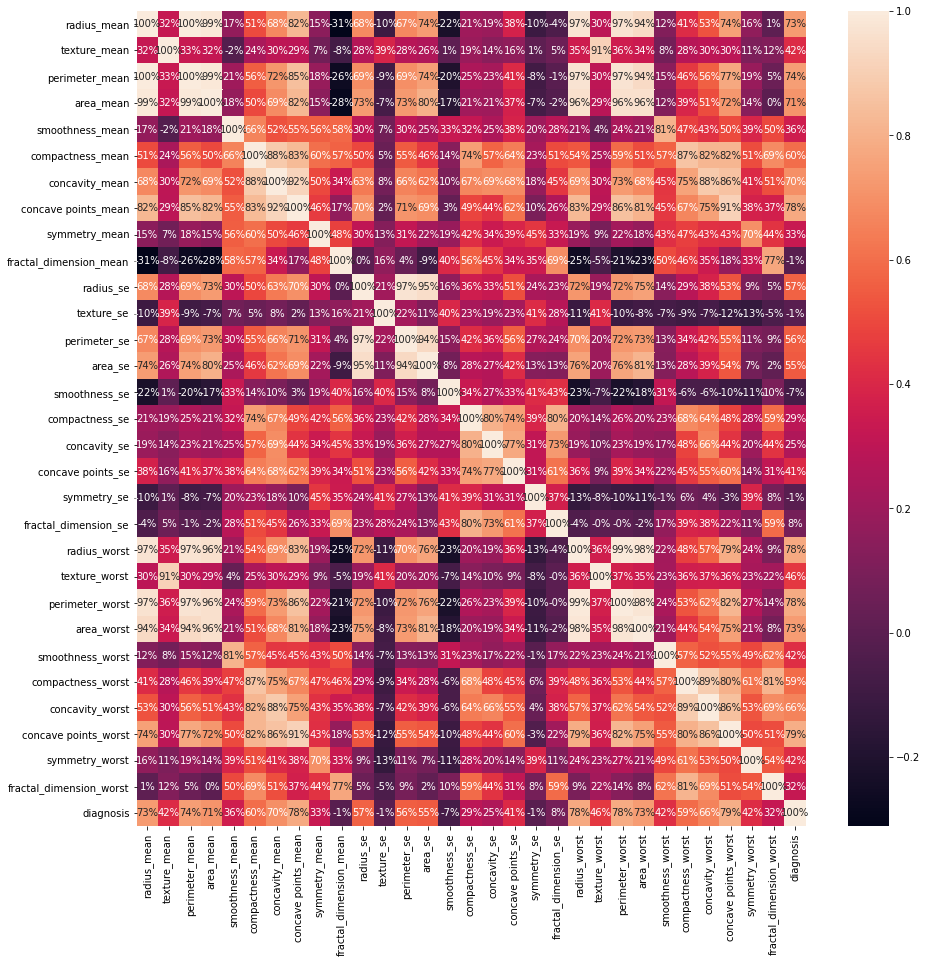

In [0]:
# check the colum correlations
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix(sdf, sdf.columns), annot=True, fmt='.0%')

In [0]:
# drop some high correlated columns
column_names = ['fractal_dimension_mean', 'texture_se', 'symmetry_se', 'radius_worst', 'radius_mean']
sdf = sdf.drop(*column_names)

In [0]:
# create dataframe with a features vector that will be used for all ML models
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=sdf.drop('diagnosis').columns, outputCol='features')
sdf_final = vec_assembler.transform(sdf).select('diagnosis', 'features')

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

Which model will be used? Why? What parameters?

In [0]:
# select features column for K-Means model
kmeans_data = sdf_final.select('features')

In [0]:
# normalize the data
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol='features', outputCol='normalizedFeatures')
scalerModel = scaler.fit(kmeans_data)
normalized_kmeans_data = scalerModel.transform(kmeans_data).select('normalizedFeatures')

In [0]:
# create model for original data
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='features').setK(2).setSeed(1)
model = kmeans.fit(kmeans_data)

predictions = model.transform(kmeans_data).select('prediction')
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  131|
|         0|  438|
+----------+-----+



In [0]:
# create model for normalized data
normalized_kmeans = KMeans(featuresCol='normalizedFeatures').setPredictionCol('normalizedPrediction').setK(2).setSeed(1)
normalized_model = normalized_kmeans.fit(normalized_kmeans_data)

normalized_predictions = normalized_model.transform(normalized_kmeans_data).select('normalizedPrediction')
normalized_predictions.groupBy('normalizedPrediction').count().show()

+--------------------+-----+
|normalizedPrediction|count|
+--------------------+-----+
|                   1|  192|
|                   0|  377|
+--------------------+-----+



## Clustering results<a class="anchor" id="clustering"></a>

In [0]:
# plot the results of original data predictions by reducing the dimension of features with PCA
from sklearn.decomposition import PCA

feature_array = [x.toArray() for x in kmeans_data.toPandas().values.squeeze()]
prediction_array = predictions.toPandas().values.squeeze()

reduced_data = PCA(n_components=2).fit_transform(feature_array)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

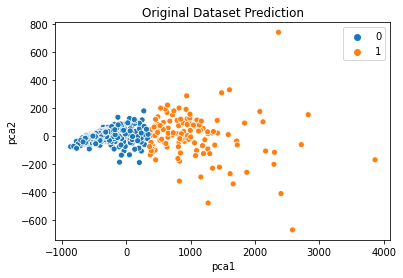

In [0]:
sns.scatterplot(x="pca1", y="pca2", hue=prediction_array, data=results)
plt.title('Original Dataset Prediction')
plt.show()

In [0]:
# plot the results of normalized data predictions by reducing the dimension of features with PCA
normalized_feature_array = [x.toArray() for x in normalized_kmeans_data.toPandas().values.squeeze()]
normalized_prediction_array = normalized_predictions.toPandas().values.squeeze()

normalized_reduced_data = PCA(n_components=2).fit_transform(normalized_feature_array)
normalized_results = pd.DataFrame(normalized_reduced_data,columns=['pca1','pca2'])

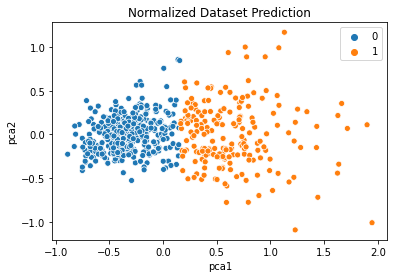

In [0]:
sns.scatterplot(x="pca1", y="pca2", hue=normalized_prediction_array, data=normalized_results)
plt.title('Normalized Dataset Prediction')
plt.show()


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

In [0]:
# split the data
train_data, test_data = sdf_final.randomSplit([0.7, 0.3], 1)

In [0]:
# normalize train data
scaler = MinMaxScaler(inputCol='features', outputCol='normalizedFeatures')
scalerModel = scaler.fit(train_data)
normalized_train_data = scalerModel.transform(train_data).select('diagnosis', 'normalizedFeatures')

In [0]:
# normalize test data
scaler = MinMaxScaler(inputCol='features', outputCol='normalizedFeatures')
scalerModel = scaler.fit(test_data)
normalized_test_data = scalerModel.transform(test_data).select('diagnosis', 'normalizedFeatures')

In [0]:
# train the LR model with original data
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(labelCol='diagnosis')
model = model.fit(train_data)

predictions = model.transform(test_data)

In [0]:
# train the LR model with normalized data
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(labelCol='diagnosis').setFeaturesCol('normalizedFeatures')
model = model.fit(normalized_train_data)

normalized_predictions = model.transform(normalized_test_data)

## Evaluation<a class="anchor" id="evaluation"></a>

In [0]:
# print the classification results for Original Model
from sklearn.metrics import classification_report, confusion_matrix

y_true = predictions.select(['diagnosis']).collect()
y_pred = predictions.select(['prediction']).collect()

print("Evaluation Metrics for Original Model")
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Evaluation Metrics for Original Model
[[95  9]
 [ 8 45]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       104
         1.0       0.83      0.85      0.84        53

    accuracy                           0.89       157
   macro avg       0.88      0.88      0.88       157
weighted avg       0.89      0.89      0.89       157



In [0]:
# print the classification results for Normalized Model
y_true = normalized_predictions.select(['diagnosis']).collect()
y_pred = normalized_predictions.select(['prediction']).collect()

print("Evaluation Metrics for Normalized Model")
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Evaluation Metrics for Normalized Model
[[68 36]
 [ 0 53]]
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79       104
         1.0       0.60      1.00      0.75        53

    accuracy                           0.77       157
   macro avg       0.80      0.83      0.77       157
weighted avg       0.86      0.77      0.78       157



## References<a class="anchor" id="references"></a>

https://youtu.be/PRzSWWsyHZg            
https://youtu.be/oDTJxEl95Go      


**Disclaimer!** <font color='grey'>This notebook was prepared by Halil Etka Tutkun for educational purposes. There is no guarantee on the correctness of the content provided.

If you think there is any copyright violation, please let me know 
</font>